# Bandit Algorithms vs AB Tests
[J. Nathan Matias](https://natematias.com), April 3, 2019

This notebook is part of [SOC412, Designing Field Experiments at Scale](https://natematias.com/courses/soc412/syllabus.html)

In [330]:
%matplotlib inline
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
import scipy                      # Scipy for confidence intervals of the mean
from dateutil import *            # I prefer dateutil for parsing dates
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
import statsmodels.stats as stats # access to ttest_ind
from collections import Counter, defaultdict   # Counter is useful for grouping and counting
import string, copy

cbbPalette = ["#000000", "#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]

## Simulate Data Potential Outcomes

To begin, imagine that you have multiple possible interventions, and that for each person, there is a potential outcome from receiving that intervention. 

In this part of the code, I simulate those potential outcomes for each participant across six possible conditions, each of which has a different normally distributed outcome (payoff).

In [461]:
## this method returns a pandas dataframe that contains
## all potential outcomes for a simulated set of possible interventions
## We use this simulation to test the multi-armed bandit

def sim_potential_outcomes(n, arm_means, arm_sds):
    dfhash = {}
    if(len(arm_means)!= len(arm_sds)):
        raise Exception("arm_means and arm_sds do not have the same length")
    elif(len(arm_means) > len(string.ascii_lowercase)):
        raise Exception("more arms requested than lowercase letters in ASCII *blush*")
    i = 0
    for mean in arm_means:
        key = string.ascii_lowercase[i]
        dfhash[key] = np.random.normal(mean,arm_sds[i], n)
        i += 1
    return pd.DataFrame(dfhash)

The code below defines and shows the distribution of potential outcomes for every participant, for each of the 6 possible interventions (also called *arms*).

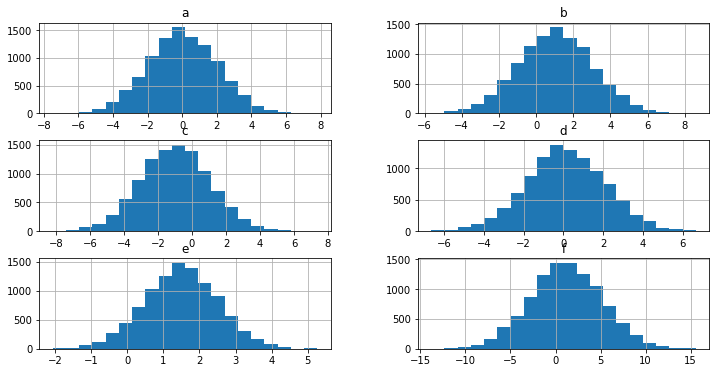

In [463]:
payoff_means = [0, 1, -1, 0.1, 1.5, 1.2]
payoff_sds   =  [2,2,2,2,1,4]
sim_df = sim_potential_outcomes(10000, payoff_means, payoff_sds)
sim_df.hist(bins=20, figsize=(12,6))
plt.show()

### What is the maximum outcome from perfect knowledge?
To achieve the maximum average outcome, we would invest only in **arm E**, which has a payoff of **1.5** on average. Let's assume that the "payout" is cumulative and reversible (like dollars) or that it makes sense to talk about the payout building up over time.

With those assumptions, for a given number of participants (N), we would expect that the **maximum average payout** would be **N * 1.5**. 

The minimum payout would occur if we always chose the worst intervention (C, which has an average outcome of -1).  Here, the **minimum average payout** is **N * -1**. 

If we randomly assigned interventions, we would get the **random payout**, which is the average outcome of all of the interventions (0.47). The **average random payout** here would be **N * 0.47** though it could easily be a negative number.

The maximum and minimum average payout are the upper and lower bounds of what is possible with these arms.

## What would be the total payout of doing an A/B test if we waited for statistical significance before making a decision?

In an experiment, we would randomly assign interventions to participants until we determined which arm was the best. Then we would make a decision. Under those circumstances:
* During the experiment, we get the average random payout
* Upon making a decision, we get the maximum average payout (if we identified the best performing arm)

Imagine we did a power analysis and determined that to reach 80% power with a 0.3 effect size, we would need 2791 observations per arm (this is based on a [rough power calculation on egap](https://egap.shinyapps.io/power-app/), and number is probably different from this, but let's work with this for the sake of argument). With **six arms** we would need **2,791 * 6 = 16,746** participants to distinguish differences between each arm. 

Now **imagine that we had a total budget of 20,000 actions** we could take and we had to spend 16,746 on the experiment. During the **exploration** phase, we would be putting resources into learning what intervention was most effective. In the **exploitation** phase, we would be using that intervention everywhere in order to maximize the payoff.

The total payoff we would get from the above simulated data would be as follows:

In [468]:
total_actions = 20000
per_arm = 2791

maximum_avg_payoff = total_actions * payoff_means[4]
abtest_avg_payoff  = per_arm * payoff_means[0] +     \
                     per_arm * payoff_means[1] +     \
                     per_arm * payoff_means[2] +     \
                     per_arm * payoff_means[3] +     \
                     per_arm * payoff_means[4] +     \
                     per_arm * payoff_means[5] +     \
                     payoff_means[4] * (total_actions - per_arm * 6)
random_avg_payoff      = np.mean(payoff_means) * total_actions

print("Maximum average payoff: {:0.2f}".format(maximum_avg_payoff))
print("Random average payoff: {:0.2f}".format(random_avg_payoff))
print("AB Test average payoff: {:0.2f}".format(abtest_avg_payoff))

Maximum average payoff: 30000.00
Random average payoff: 9333.33
AB Test average payoff: 12695.80


In the above case, an A/B test would provide a better payoff than random, but far less than the maximum average payoff. 

**REGRET**: the difference between the maximum average payoff (with perfect knowledge) and the payoff you received.

**Is it possible to have less regret than we would have from A/B tests?** Yes! If the following conditions are met:
* we are assigning new participants to receive interventions *over time*
* it is possible to *incorporate data about past outcomes into decisions* about what interventions to assign (for example,if we are regularly receiving back data *before* assigning new interventions to participants)
* we have a *cumulative* or *reversible* outcome where positive outcomes balance out or cancel out negative outcomes (important from an ethics standpoint– though there are other special cases where harm reduction values might also lead us to consider bandits)

If those conditions are met, then **bandit algorithms** can sometimes minimize regret

![bandits vs ab tests](https://github.com/natematias/SOC412/raw/master/lecture-code/images/bandit-vs-abtest.png)

## Bandit Algorithm Example: Upper Confidence Bound
The purpose of bandit algorithms is to minimize regret.

In this example, I implement a very simple **upper confidence bound** algorithm, which makes  one observation for each intervention (arm), and then always chooses the arm with the highest confidence interval. This bandit is operating in the "static" case where we don't expect the payoff from these arms to be changing over time. The bandit takes the following steps:

* for the first # trials, **sample randomly from the arms** to get information about the distribution of each arm
* for all subsequent trials, "pull" the arm with the **highest upper confidence bound**

<span style="color:red">Don't use this bandit code in practice without substantial modification, it's designed as a simple illustration of an approach that corresponds well to the intuitions of frequentist statisticians.</span>

In [470]:
def ucb_bandit(num_arms, min_arm_obs, num_trials, all_payoff_means, potential_outcomes):
    arm_columns = string.ascii_lowercase[0:num_arms]
    bandit_history = {"arms":{}, "actions":[{"payoff":0, "regret":0, "arm":None, "arm_payoff":None}]}
    max_avg_payoff = max(all_payoff_means)
    
    for arm in arm_columns:
        bandit_history["arms"][arm] = []

    for i in range(num_trials):
        trial = i

        arms_under_min = [key for key in bandit_history["arms"].keys() 
                          if len(bandit_history["arms"][key])<min_arm_obs]

        ## choose a random arm if we are below the minimum observations
        if(len(arms_under_min)>0):
            next_arm = np.random.choice(arms_under_min, 1)[0]
            ## now take the potential outcome from the chosen arm
            ## reveal it and add it to the history of the bandit
            arm_payoff = potential_outcomes[next_arm][i]
            bandit_history["arms"][next_arm].append(
                arm_payoff
            )
            
            bandit_history["actions"].append({
                "arm": next_arm,
                "arm_payoff": arm_payoff,
                "payoff": bandit_history["actions"][-1]['payoff'] + arm_payoff,
                "regret": bandit_history["actions"][-1]['regret'] + (max_avg_payoff - arm_payoff)
            })

        ## otherwise choose based on the highest upper confidence interval
        else:
            upr_confint = {}
            for col in arm_columns:
                upr_confint[np.mean(bandit_history["arms"][col]) + 1.96 * np.std(bandit_history["arms"][col])] = col
            top_arm = upr_confint[np.max(list(upr_confint.keys()))]

            ## now take the potential outcome from the chosen arm
            ## reveal it and add it to the history of the bandit
            arm_payoff = potential_outcomes[top_arm][i]
            bandit_history["arms"][top_arm].append(
                arm_payoff
            )
            
            bandit_history["actions"].append({
                "arm": next_arm,
                "arm_payoff": arm_payoff,
                "payoff": bandit_history["actions"][-1]['payoff'] + arm_payoff,
                "regret": bandit_history["actions"][-1]['regret'] + (max_avg_payoff - arm_payoff)
            })

            
    return bandit_history

### Example: Plot the cumulative regret from multiple runs of the upper confidence bound bandit algorithm

In this example, I simulate 10 different runs of the same bandit algorithm that randomly assigns each intervention one time before consistently choosing the upper confidence bound, over 500 trials. 

In [471]:
num_trials = 500
test_run_count = 10
min_arm_obs = 1

## initialize histories with the payoff from random selection
histories = []
histories.append({"payoff":[], "regret":[]})
payoff_mean = np.mean(payoff_means)
max_payoff = max(payoff_means)
for i in range(num_trials):
    histories[0]['payoff'].append(i * payoff_mean)
    histories[0]['regret'].append(i * max_payoff - i * payoff_mean)
histories[0]['final_arm']  = "RANDOM"

## conduct num_trials bandit runs
for i in range(test_run_count):
    history = ucb_bandit(num_arms=len(payoff_means), min_arm_obs=min_arm_obs, num_trials = num_trials, all_payoff_means = payoff_means, 
               potential_outcomes = sim_df)
    payoffs = [x['payoff'] for x in history['actions']]
    regrets = [x['regret'] for x in history['actions']]
    histories.append({"payoff": payoffs, "regret": regrets, "final_arm":history['actions'][-1]['arm']})

The plot below shows the cumulative regret of each run of the bandit algorithm, compared to the straight black line, which is the cumulative regret from doing an A/B test. As you can see, all but one of the runs of the bandit algorithm delivered much less regret over time than a random sample.

Text(0.5, 1.0, 'Cumulative regret over multiple runs')

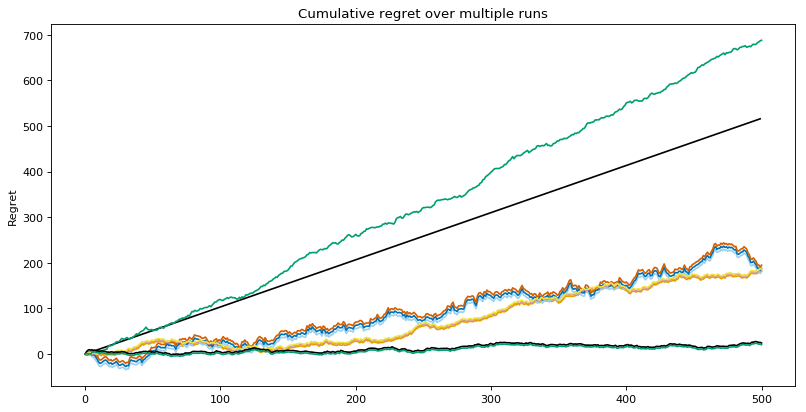

In [473]:
plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(test_run_count):
    plt.plot(histories[i]['regret'], cbbPalette[i % 8])
    plt.ylabel("Regret")
plt.title("Cumulative regret over multiple runs")

You will **however see that one run of the bandit got stuck** - in the very first set of observations, one of the intervention arms must have returned an unusually high draw, causing the algorithm to stick with  a poorly-performing intervention over time.

There are many bandit algorithms, and some of the research on bandit algorithms investigates different ways to avoid the problem of bandits that get stuck in "local maxima" like that one run of the algorithm. 

For the upper confidence bound (UCB) algorithm, we can reduce this risk by randomly sampling a greater number of observations from each arm before making decisions based on the UCB. In the below example, we randomly assign 5 participants per intervention before making decisions based on UCB.

When reading the chart, notice that when we increase the number of random assignments at the beginning, the UCB algorithm's regret follows the random sample line before diverging to optimize exploitation of lower regret interventions.

In [526]:
num_trials = 500
test_run_count = 10
min_arm_obs = 5 #<- changed this to 5

## initialize histories with the payoff from random selection
histories = []
histories.append({"payoff":[], "regret":[]})
payoff_mean = np.mean(payoff_means)
max_payoff = max(payoff_means)
for i in range(num_trials):
    histories[0]['payoff'].append(i * payoff_mean)
    histories[0]['regret'].append(i * max_payoff - i * payoff_mean)
histories[0]['final_arm']  = "RANDOM"

## conduct num_trials bandit runs
for i in range(test_run_count):
    history = ucb_bandit(num_arms=len(payoff_means), min_arm_obs=min_arm_obs, num_trials = num_trials, all_payoff_means = payoff_means, 
               potential_outcomes = sim_df)
    payoffs = [x['payoff'] for x in history['actions']]
    regrets = [x['regret'] for x in history['actions']]
    histories.append({"payoff": payoffs, "regret": regrets, "final_arm":history['actions'][-1]['arm']})

Text(0.5, 1.0, 'Cumulative regret over multiple runs')

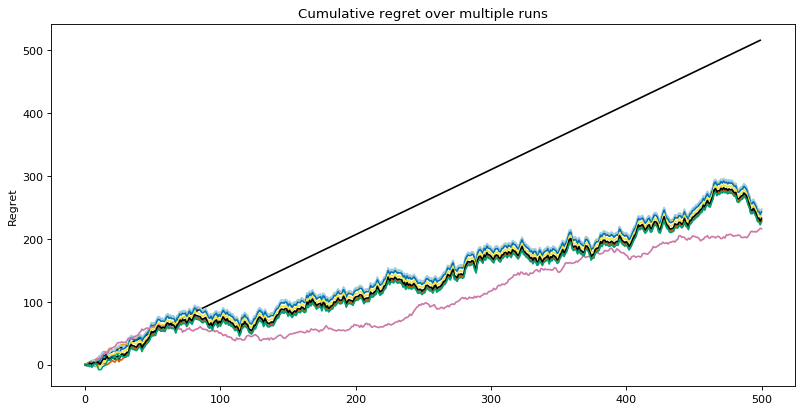

In [527]:
plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(test_run_count):
    plt.plot(histories[i]['regret'], cbbPalette[i % 8])
    plt.ylabel("Regret")
plt.title("Cumulative regret over multiple runs")

## Scratch Area for Methods I Didn't Use

In [489]:
## randomly assign each arm and reveal the outcome 
## for up to N observations
def assign_and_reveal(n, arms, sim_df):
    sdf = copy.copy(sim_df)
    sdf['condition'] = pd.Series([string.ascii_lowercase[i] for i in np.random.choice(arms, len(sdf))])
    conditions = []
    outcomes = []
    i = 0
    for index, row in sdf.iterrows():
        if(i>=n):
            continue
        conditions.append(row['condition'])
        outcomes.append(row[row['condition']])
        i+= 1
    return pd.DataFrame({"condition":conditions, "outcome":outcomes})

In [154]:
def simulate_comparisons(n, arms, sim_df):
    if(n % arms != 0):
        raise Exception("n should be divisible by arms with no remainder")
    sim_reveal = assign_and_reveal(n, 6, sim_df)
    results = defaultdict(lambda: {"comp":None, "tstat":None, "pvalue":None})
    for a in string.ascii_lowercase[0:arms]:
        for b in string.ascii_lowercase[0:arms]:
            if(a == b):
                continue
            test = stats.weightstats.ttest_ind(sim_reveal[sim_reveal['condition'] == a]['outcome'].tolist(), 
                                sim_reveal[sim_reveal['condition'] == b]['outcome'].tolist())
            key = a + b
            results[key]['comp'] = key
            results[key]['tstat'] = test[0]
            results[key]['pvalue'] = test[1]
    return results

## You are Free to Copy & Reuse this Code¶ 
Copyright 2019 J. Nathan Matias

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.